<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/TimeSeriesForecasting/solutions/decision_under_uncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single stage decisions

## Demand side management through ripple control
In this example we want to estimate the distribution of the activation time of an heat pump, knowing historical values of the power measurements of its household and having a forecast of tomorrow temperature.
The problem can be stated as finding the solution of the following problem:
**\begin{align} &\min_{u} u\\
&s.t.:  \mathbb{E}_W(h_{eq}(\hat{T}_d(w))<u)<0.9\end{align}**
where $h_{eq}$ is the estimated equivalent number of hours the HP must be active to heat up the building. As we've seen during the lecture, **this boils down to estimating the 90% quantile of the pdf of $h_{eq}(\hat{T}_d(w))$**.


We can tackle the problem of finding the PDF of $h_eq$ in three steps:
* estimate the nominal power of the HP  $\hat{P}_{hp}$. Usually, devices are not directly measuered, and metadata are rarely available. This means that we have to estimate the nominal power of the HP directly from the meter measurements.
* estimate the energy signature of the household as a funciton of the predicted average external temperature $\hat{E}_{d}(\hat{T}_d)$
* estimate the forecasting error for the estimation of the average daily tempearture $\hat{T}_d$

Finally, we can combine these estimations to retrieve the expected time needede by the HP to heat the household as, in terms of equivalent hours:

$$h_{eq} = \frac{\hat{E}_{d}(\hat{T}_d)}{\hat{P}_{hp}}$$

Needless to say, both $\hat{P}_{hp}$ and $\hat{E}_{d}(\hat{T}_d)$ are probabilistc estimations with associated variance, which we'll have to properly consider when estimating $\hat{h}_{eq}$.

We start by loading the household dataset:

In [1]:
!git clone https://github.com/nepslor/teaching.git
!pip install pandas==1.5.1


Cloning into 'teaching'...
remote: Enumerating objects: 777, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (188/188), done.
remote: Total 777 (delta 155), reused 155 (delta 78), pack-reused 511
Receiving objects: 100% (777/777), 190.16 MiB | 13.33 MiB/s, done.
Resolving deltas: 100% (407/407), done.
Updating files: 100% (91/91), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 20.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.5.3, but you have pandas 1.5.1 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from teaching.TimeSeriesForecasting.utils.merge_ramps import merge_ramps

data = pd.read_pickle('teaching/TimeSeriesForecasting/data/energy_signature_data.zip')
data.head()


,GHI,T,heat_pump_p,heat_pump_q,main_p,main_q,relay,nwp_temperature,nwp_ghi
2015-10-01 00:00:00+00:00,-2.781167,9.500000,0.0,0.0,0.407500,0.520833,NaN,NaN,NaN
2015-10-01 00:01:00+00:00,-2.803333,9.496667,0.0,0.0,0.435333,0.520500,NaN,NaN,NaN
2015-10-01 00:02:00+00:00,-2.856000,9.400000,0.0,0.0,0.423833,0.521500,NaN,NaN,NaN
2015-10-01 00:03:00+00:00,-2.886833,9.400000,0.0,0.0,0.402000,0.517667,NaN,NaN,NaN
2015-10-01 00:04:00+00:00,-2.911667,9.400000,0.0,0.0,0.400833,0.516833,NaN,NaN,NaN


### Nominal power estimation
Before detecting the HP nominal power, derivatives and observations must be at first merged, since sampling introduce dispersion in the distribution of the power jumps, making it difficult to spot accumulation points.


<center>
<img src="https://raw.githubusercontent.com/nepslor/teaching/main/TimeSeriesForecasting/figs/merging_derivatives.png" width="400", centered=True>
</center>

<font size="-2"><p><center>Example of sampling-induced dispersion. Blue: before merging derivatives. Orange: after merging, clusters are clearly visible</center></p></font>

This is the task of the function `merge_ramps` that we've loaded from the course repo. 


In [3]:
data_diffs = data.copy()
for k in ['main_p', 'main_q', 'heat_pump_p', 'heat_pump_q']:
  data_diffs[k].iloc[:-1], _, _ = merge_ramps(data[k])

# Estimation of HP nominal power 
The nominal power of the HP can be estimated looking at power jumps. In this dataset we have both the measurements from the HP and the the state of the relee controlling the HP. A smart way to assess the nominal power would be to look at moment in time in which the relee which disconnects the HP change state.

We can have a look at the distribution of power jumps for these three variables:
1. power jumps of the smart meter power 
2. power jumps of the HP's power (that we will use only as a reference)
3. power jumps of the HP's power, filtered by positive jumps of the relay status (that is, when the HP is being switched off)
 

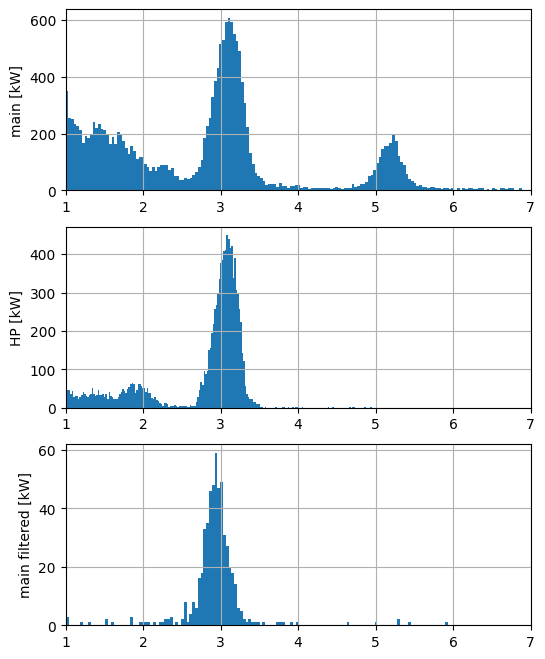

In [4]:
n_bins = 200

filt = data_diffs['main_p']>1
relay_on_filt = np.roll(data[['relay']].diff().values==1, 1)

fig, ax= plt.subplots(3, 1, figsize=(6, 8))

data_diffs['main_p'].loc[filt].\
    hist(bins=n_bins*2, ax=ax[0])

data_diffs['heat_pump_p'].loc[data_diffs['heat_pump_p']>1].\
    hist(bins=n_bins, ax=ax[1])

main_jumps = data_diffs['main_p'].loc[relay_on_filt]
main_jumps_when_on = main_jumps.loc[main_jumps>1]
main_jumps_when_on.hist(bins=n_bins, ax=ax[2])
[a.set_ylabel(t) for a, t in zip(ax, ['main [kW]', 'HP [kW]', 'main filtered [kW]'])]
[a.set_xlim([1, 7]) for a in ax.ravel()];


### 🥋 EX 1: find sampling PDF for the HP's power
Starting from the variable `main_jumps_when_on`, find a reasonable PDF for the HP's power by filtering out outliers. Call the resulting filtered observations `p_pdf`

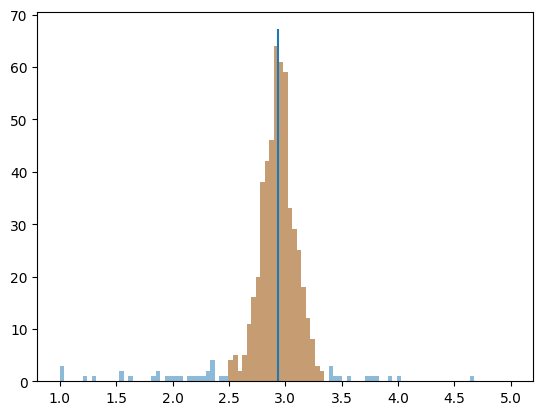

In [5]:
def filter_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df.loc[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))]


# find the PDF for the nominal power to sample from
p_pdf = filter_outliers(main_jumps_when_on)
p_exp = np.mean(p_pdf)

fig, ax = plt.subplots(1, 1)
ax.hist(main_jumps_when_on, bins=np.linspace(1, 5, 100), alpha=0.5)
ax.hist(p_pdf, bins=np.linspace(1, 5, 100), alpha=0.5)
ax.vlines(p_exp, *plt.ylim())
plt.show()

# Energy signature
In the following we'll fit a picewise linear function on the average values of measured external temperature and power at the household's main. We need to fit a piecewise function since we assume that after a given temperature the HP wont' be activated (in this household the HP is just used for space heating and not for cooling).



[ 1.27064480e+01 -1.40247647e-01  1.03433662e+00 -3.88079709e+00
  2.50000000e+01  4.26064996e-03]


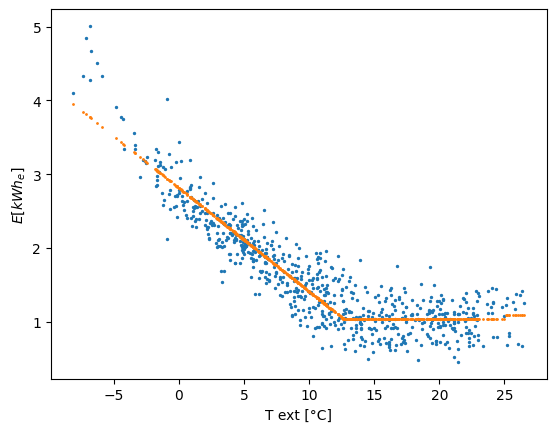

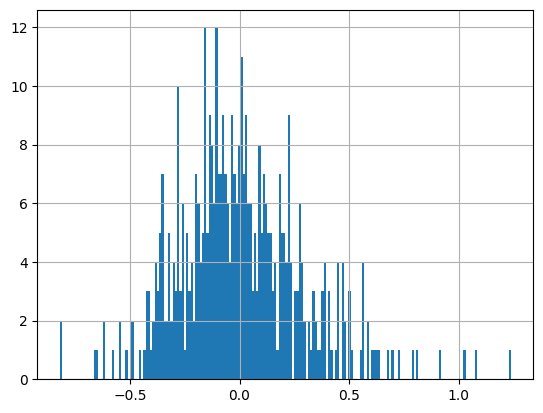

In [9]:

# fit an energy signature
from scipy import optimize

def es_fun(k, T):
    return np.piecewise(T, [T < k[0],T > k[4]], [lambda T:k[1]*T + k[2]-k[1]*k[0], lambda T:k[5]*T + k[2]-k[5]*k[0], lambda T: k[2]])
x0 = np.array([15, -1, 5, 0, 25, 1])

T = data['T'].resample('1d').mean()
p = data['main_p'].resample('1d').mean()
min_bounds = np.array([10, -100, 0, -10, 20,0]) 
max_bounds = np.array([20, 0, np.inf, 10, 30, np.inf]) 
res_robust = optimize.least_squares(lambda k, T, y: es_fun(k, T)-p, x0, args=(T.values, p.values), loss='huber', bounds=(min_bounds, max_bounds))
print(res_robust.x)

# find errors when the HP is active
fig, ax = plt.subplots(1, 1)
ax.scatter(T, p, s=2)
ax.scatter(T, es_fun(res_robust.x, T.values), s=1)
ax.set_xlabel('T ext [°C]')
ax.set_ylabel('$E [kWh_e]$')
plt.show()

residuals = p-(es_fun(res_robust.x, T.values))
residuals_hp_on = residuals.loc[T<res_robust.x[0]]
residuals_hp_on.hist(bins=n_bins)
plt.show()

es_pdf = residuals_hp_on
es_pdf.name = 'es'

### 🥋 EX2: find the PDF for the NWP's mean external temperature
Starting from the `nwp_temperature` column, retrieve the PDF of the prediction errors for the external temperature provided by the NWP provider. Call it `T_pdf`

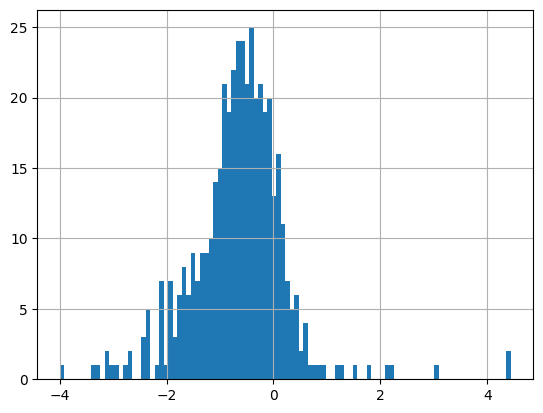

In [12]:
d_data = data.resample('1d').mean()
filt = ~d_data['nwp_temperature'].isna()
T_pdf = d_data.loc[filt]['T'] -d_data.loc[filt]['nwp_temperature']
T_pdf.name = 'T_nwp'
T_pdf.hist(bins=100)
plt.show()

In the following cell we define the function `get_cdf` which returns an interpolated CDF from the original observations


<Axes: >

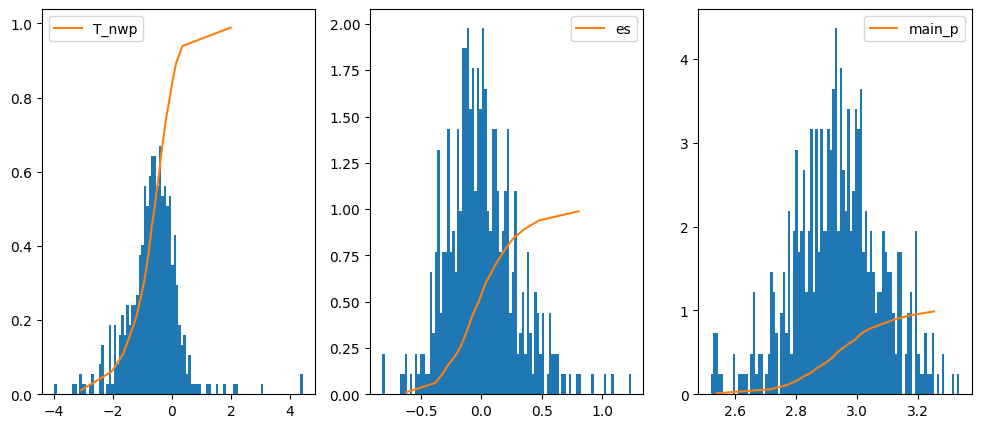

In [13]:
def get_cdf(df, q_levels):
  n = len(df)
  quantiles = np.quantile(df, q_levels)
  cdf = [np.sum(df<q)/n for q in quantiles]
  return pd.DataFrame(cdf, index=quantiles, columns=[df.name])

q_levels = np.linspace(0.01, 0.99, 21)
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
T_pdf.hist(ax=ax[0], density=True, bins=100)
get_cdf(T_pdf, q_levels).plot(ax=ax[0])
es_pdf.hist(ax=ax[1], density=True, bins=100)
get_cdf(es_pdf, q_levels).plot(ax=ax[1])
p_pdf.hist(ax=ax[2], density=True, bins=100)
get_cdf(p_pdf, q_levels).plot(ax=ax[2])


## Dealing with uncertainty in the estimated PDF
We have now retrieved three distributions for the inputs of the function estimating the equivalent number of hours. This would be enough to estimate 
$$h_{eq} = \frac{\hat{E}_{d}(\hat{T}_d)}{\hat{P}_{hp}}$$
through Monte Carlo sampling.
However, we can make a step further, extimating the aleatoric uncerainty in the estimation of these three distributions. This can be done using the Kolmogorov-Smirnov test. The null hypotesis of the test is that two CDF comes from the same iid random variable, and it's based on the statistics $$D_n=\sup _x\left|F_n(x)-F(x)\right|$$
which is, the maximum discrepancy between the two CDF.
<div><center>
<img src="https://raw.githubusercontent.com/nepslor/teaching/main/TimeSeriesForecasting/figs/KS.png" width="400"/>
</div></center>

Given the number of samples used and a level of confidence, we can invert the test and find the maximum discrepancy needed by two CDF to be considered differnet, having observed at least n samples.
<div><center>
<img src="https://raw.githubusercontent.com/nepslor/teaching/main/TimeSeriesForecasting/figs/KS_table.png" width="400"/>
</center>
</div>

This method can be used to build confidence intervals around the observed empirical CDF.

<Axes: >

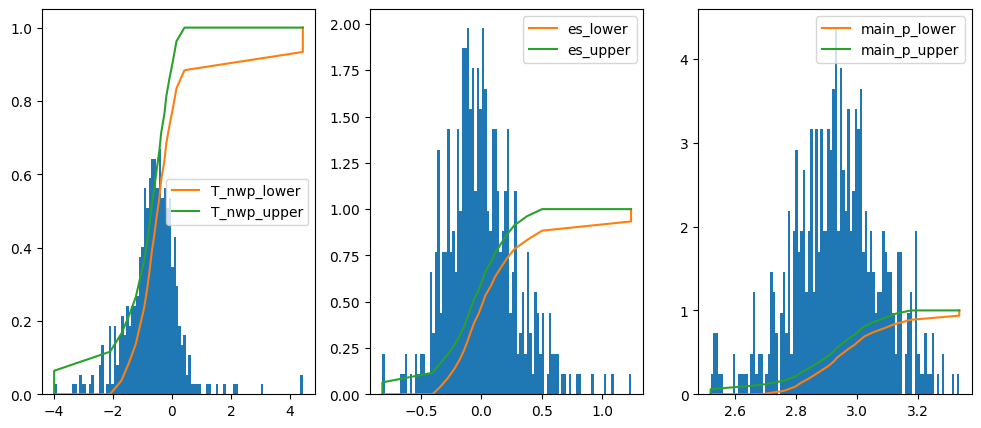

In [14]:
from scipy.stats import ksone

def ks_critical_value(n_trials, alpha):
    return ksone.ppf(1-alpha/2, n_trials)

def get_cdf_boundaries(df, q_levels, alpha_level=0.05):
  n = len(df)
  ks_val = ks_critical_value(n, alpha_level)
  quantiles = np.quantile(df, q_levels)
  cdf = [np.sum(df<q)/n for q in quantiles]
  lower_bound = np.minimum(1, np.maximum(0, cdf -ks_val))
  upper_bound = np.minimum(1, np.maximum(0, cdf +ks_val))
  lower_bound = np.hstack([0, lower_bound, 1])
  upper_bound = np.hstack([0, upper_bound, 1])
  cdf_lims = np.vstack([lower_bound, upper_bound]).T
  return pd.DataFrame(cdf_lims, index=np.hstack([quantiles[0]-1e-6, quantiles,quantiles[-1]+1e-6]), columns=['{}_lower'.format(df.name), '{}_upper'.format(df.name)])

q_levels = np.linspace(0, 1, 21)
T_cdf_bounds = get_cdf_boundaries(T_pdf, q_levels)
es_cdf_bounds = get_cdf_boundaries(es_pdf, q_levels)
p_cdf_bounds = get_cdf_boundaries(p_pdf, q_levels)
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

T_pdf.hist(ax=ax[0], density=True, bins=100)
T_cdf_bounds.plot(ax=ax[0])

es_pdf.hist(ax=ax[1], density=True, bins=100)
es_cdf_bounds.plot(ax=ax[1])

p_pdf.hist(ax=ax[2], density=True, bins=100)
p_cdf_bounds.plot(ax=ax[2])


We can define a class CDFBoundarySampler performing a MonteCarlo sampling of our interval sets:

In [15]:
from scipy.interpolate import interp1d

class CDFBoundarySampler:
  def __init__(self, df):
    self.f_lower = interp1d(df.iloc[:, 0], df.index)
    self.f_upper = interp1d(df.iloc[:, 1], df.index)
    
  def sample(self, n_samples, n_inner_samples=1):
    seeds = np.random.rand(n_samples)
    samples = []
    for i, seed in enumerate(seeds):
      
      # for each seed, intercept the lower and upper CDFs on their y
      lower_bound = self.f_lower(seed)
      upper_bound = self.f_upper(seed)

      # take n_inner_samples samples of the uncertain segment that has been randomly picked
      samples.append((np.random.rand(n_inner_samples)) * (upper_bound-lower_bound) + lower_bound)
    return np.hstack(samples)

T_sampler = CDFBoundarySampler(T_cdf_bounds)
es_sampler = CDFBoundarySampler(es_cdf_bounds)
p_sampler = CDFBoundarySampler(p_cdf_bounds)


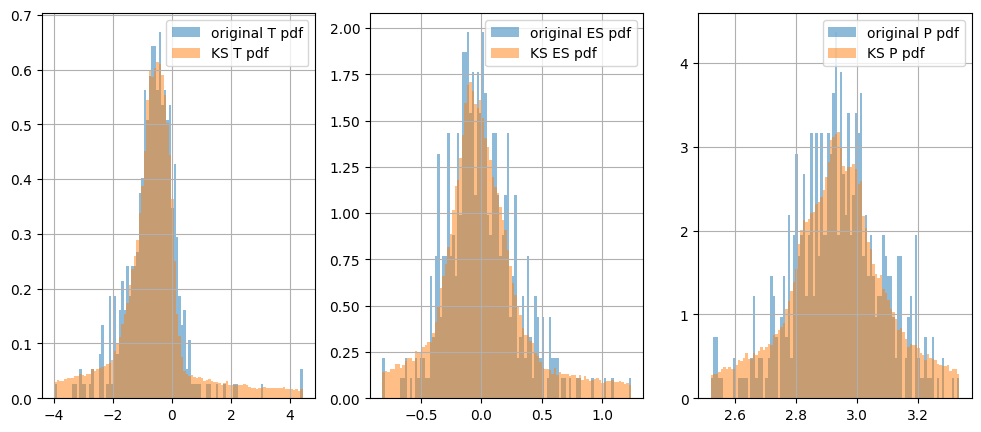

In [16]:
n_samples = 100000
T_samples = T_sampler.sample(n_samples)
es_samples = es_sampler.sample(n_samples)
p_samples = p_sampler.sample(n_samples)

fig, ax = plt.subplots(1, 3, figsize=(12, 5))
T_pdf.hist(ax=ax[0], density=True, bins=100, alpha=0.5, label='original T pdf')
ax[0].hist(T_samples, density=True, bins=100, alpha=0.5, label='KS T pdf')

es_pdf.hist(ax=ax[1], density=True, bins=100, alpha=0.5, label='original ES pdf')
ax[1].hist(es_samples, density=True, bins=100, alpha=0.5, label='KS ES pdf')

p_pdf.hist(ax=ax[2], density=True, bins=100, alpha=0.5, label='original P pdf')
ax[2].hist(p_samples, density=True, bins=100, alpha=0.5, label='KS P pdf')
[a.legend() for a in ax.ravel()];

## Monte Carlo estimation
We can now take a MonteCarlo estimation sampling from the "expanded" CDFs.
We took 1e5 samples, for each of which:
* we randomly sampled the three variables influencing $h_{eq}$ using  `CDFBoundarySampler`
* we computed the $h_{eq}$ using the `activation_time` function, for a given external temperature 

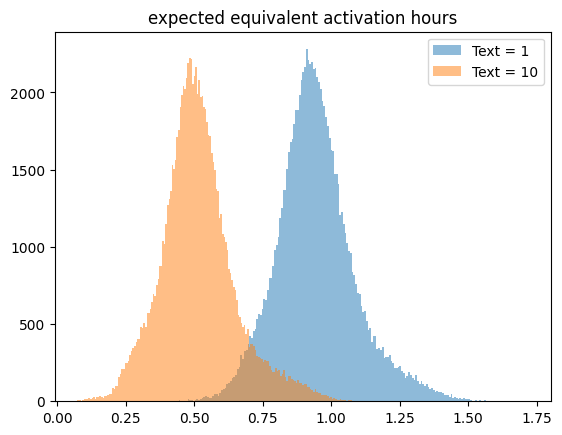

In [17]:
from functools import partial 

def activation_time(t_error, es_error, p_hp, es_function, t_ref=10):
  temperature = t_ref + t_error
  energy_needed = es_function(temperature) + es_error 
  hours = energy_needed / p_hp
  return hours

T_low = 1
T_high = 10

a_T1 = activation_time(T_samples, es_samples, p_samples, partial(es_fun, res_robust.x), t_ref=T_low)
a_T10 = activation_time(T_samples, es_samples, p_samples, partial(es_fun, res_robust.x), t_ref=T_high)

plt.hist(a_T1, bins=200, label='Text = {}'.format(T_low), alpha=0.5);
plt.hist(a_T10, bins=200, label='Text = {}'.format(T_high), alpha=0.5);
plt.legend()
plt.title('expected equivalent activation hours');

We could now take the 90% quantile of the distribution as our estimation of hours the HP has to be turned on in the next day to cover the energy needs of the household.

# Genergalized uncertainty propagation
We can retrieve a better, more conservative estimation, propagating the uncertainty. This process will return two "extreme" distributions of the output function, $h_{eq}$. We could retrieve these solving an optimization process for both the extreme CDFs, for all the points on the y axis. A more straightforward approach is to approximate the optimization via sampling:
* sample three variables, choosing an y value on their CDF at random
* for these values, sample 100 times from the uncertainty set identified by intercepting their upper and lower CDFs.  
* for each of the 100 inner samples, compute $h_{eq}$, then find the min and max values. 
* repeat the process 10000 times

This process will result in 2 series of 10000 points, which can be used to 



In [18]:
class GeneralizedUncertaintyPropagation:
  def __init__(self, boundary_samplers, model):
    self.boundary_samplers = boundary_samplers
    self.model = model

  def sample(self, n_outer, n_samples=1, n_inner_samples=100):
    seeds = np.random.rand(n_outer)
    pdf_out_min, pdf_out_max = np.zeros(n_outer), np.zeros(n_outer)
    # for all the trials
    for i, seed in enumerate(seeds):
      inner_samples = {}
      # for all the input variables
      for name, bs in self.boundary_samplers.items():
        inner_samples[name] = bs.sample(n_samples, n_inner_samples=n_inner_samples)
      # compute the output function
      inner_res = self.model(**inner_samples)
      # perform a min-max search
      pdf_out_max[i] = np.max(inner_res)
      pdf_out_min[i] = np.min(inner_res)
    return pdf_out_min, pdf_out_max

gup = GeneralizedUncertaintyPropagation({'t_error':T_sampler, 'es_error': es_sampler, 'p_hp': p_sampler}, partial(activation_time, es_function=partial(es_fun, res_robust.x), t_ref=10))
pdf_min, pdf_max = gup.sample(10000, n_inner_samples=100)


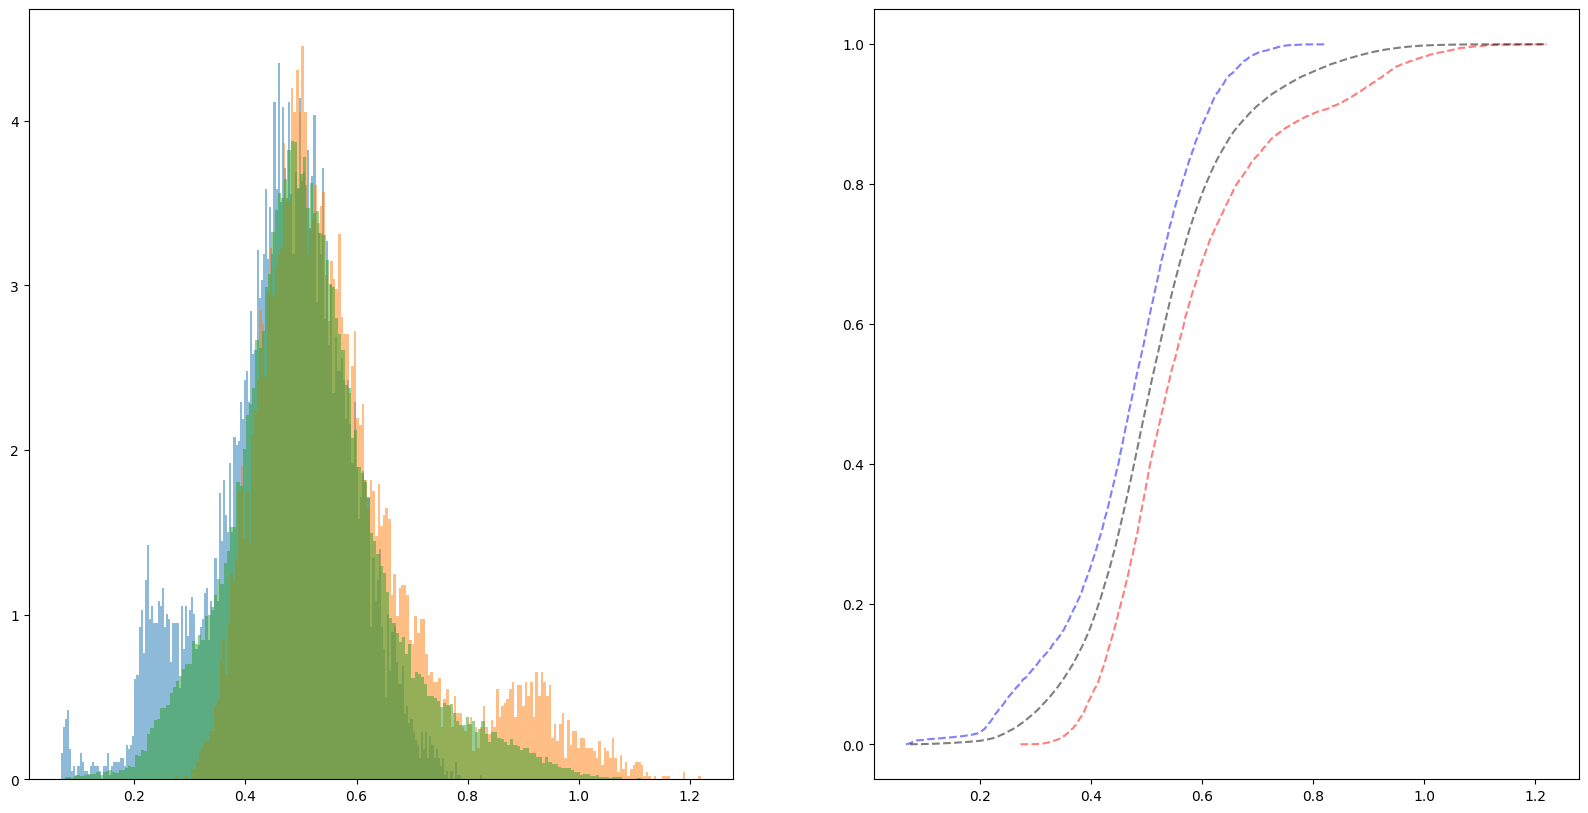

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].hist(pdf_min, bins=n_bins, alpha=0.5, density=True);
ax[0].hist(pdf_max, bins=n_bins, alpha=0.5, density=True);
ax[0].hist(a_T10, bins=n_bins, label='Text = {}'.format(T_low), alpha=0.5, density=True);


ax[1].plot(np.sort(pdf_min), np.linspace(0, 1, len(pdf_min), endpoint=False), '--b', alpha=0.5, label='Upper CDF (T=10)')
ax[1].plot(np.sort(pdf_max), np.linspace(0, 1, len(pdf_max), endpoint=False), '--r', alpha=0.5, label='Upper CDF (T=10)')
ax[1].plot(np.sort(a_T10), np.linspace(0, 1, len(a_T10), endpoint=False), '--k', alpha=0.5, label='Upper CDF (T=10)')
